# Reconocimiento Facial

Como un ejemplo de aplicación, intentaremos resolver el problema de reconocimiento facial.
Utilizaremos un dataset que consta de varios miles de fotos recopiladas de diversas figuras públicas, y esta incluído en Scikit_Learn

In [1]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np

In [2]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=60)

print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Grafiquemos algunas de las fotos, para saber con que estamos trabajando.

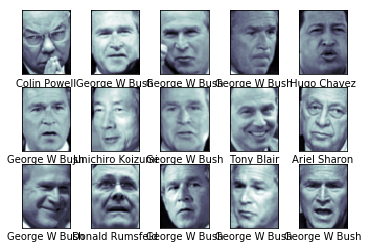

In [3]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Cada imagen contiene [62 × 47] o casi 3.000 píxeles.

Podríamos proceder simplemente usando cada valor de píxel como una característica, pero a menudo es más efectivo usar algún tipo de preprocesador para extraer características más significativas; aquí vamos a utilizar un análisis de componentes principales, PCA, para extraer 150 componentes fundamentales para alimentar a nuestro clasificador SVM. 

Haremos el split en training y test, para poder evaluar el clasificador.

In [4]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

Sobre los datos de entrenamiento podemos entrenamos el modelo PCA para reducir las dimensiones.

In [5]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)

Vamos a reducir las dimensiones del conjunto de entrenamiento con PCA

In [6]:
model_pca = pca.fit(Xtrain)
X_train_pca = model_pca.transform(Xtrain)

In [7]:
X_train_pca.shape

(1011, 150)

In [8]:
Xtrain.shape

(1011, 2914)

Finalmente, podemos usar Cross-validation para explorar una "red" de combinaciones de parámetros.
Aquí vamos a ajustar C (que controla la dureza del margen) y gamma (que controla el tamaño de la base radial del núcleo de la función), y determinar el mejor modelo:

In [11]:
from sklearn.model_selection import cross_val_score
svc_C = [1, 5, 10, 50]
svc_gamma = ['auto', 0.0001, 0.0005, 0.001, 0.005]
for c in svc_C:
    for g in svc_gamma:
        model_svc = SVC(kernel='rbf', class_weight='balanced', C=c, gamma = g)
        print (np.mean(cross_val_score(model_svc,X_train_pca,ytrain,cv=5)),' gamma:',g,' C:',c)

0.782560793111  gamma: auto  C: 1
0.100189405618  gamma: 0.0001  C: 1
0.554580745498  gamma: 0.0005  C: 1
0.792364781813  gamma: 0.001  C: 1
0.811277201411  gamma: 0.005  C: 1
0.787496589749  gamma: auto  C: 5
0.669585895752  gamma: 0.0001  C: 5
0.802189946089  gamma: 0.0005  C: 5
0.800268760081  gamma: 0.001  C: 5
0.811228118302  gamma: 0.005  C: 5
0.787481663633  gamma: auto  C: 10
0.79334647109  gamma: 0.0001  C: 10
0.796258521347  gamma: 0.0005  C: 10
0.805141017895  gamma: 0.001  C: 10
0.811238019292  gamma: 0.005  C: 10
0.787481663633  gamma: auto  C: 50
0.78648727117  gamma: 0.0001  C: 50
0.786184512401  gamma: 0.0005  C: 50
0.791204418767  gamma: 0.001  C: 50
0.812243044417  gamma: 0.005  C: 50


Los valores óptimos caen hacia el centro de nuestra red de parámetros posibles; si caen en los bordes, queremos ampliar la red para asegurarnos de que hemos encontrado el verdadero óptimo.

Ahora, con este modelo validado en forma cruzada, podemos predecir las etiquetas de los datos de prueba, que el modelo aún no ha visto:

In [12]:
model_svc_optimo = SVC(kernel='rbf', class_weight='balanced', C=10, gamma = 0.005)

Ahora ajustamos el modelo óptimo con todos los datos de entrenamiento:

In [13]:
model_svc_optimo.fit(X_train_pca,ytrain)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Predicción sobre datos no observados

In [14]:
# Primero pasamos los datos de test por el mismo proceso de reducción de dimensiones
X_test_pca = model_pca.transform(Xtest)

In [15]:
yfit = model_svc_optimo.predict(X_test_pca)

Echemos un vistazo a algunas de las imágenes de prueba junto con sus valores predichos

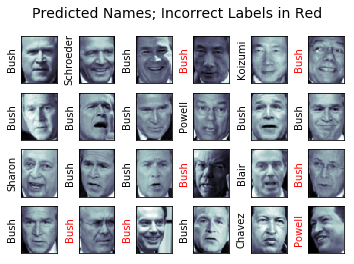

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

De esta pequeña muestra, nuestro estimador óptimo marcó erróneamente solo dos caras.
Podemos obtener un mejor sentido del desempeño de nuestro estimador usando el informe de clasificación, que enumera las estadísticas de recuperación por etiqueta:

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, yfit)

0.83976261127596441

In [18]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.47      0.64        15
     Colin Powell       0.82      0.87      0.84        68
  Donald Rumsfeld       0.87      0.65      0.74        31
    George W Bush       0.79      0.98      0.88       126
Gerhard Schroeder       0.81      0.91      0.86        23
      Hugo Chavez       1.00      0.60      0.75        20
Junichiro Koizumi       1.00      0.58      0.74        12
       Tony Blair       1.00      0.79      0.88        42

      avg / total       0.86      0.84      0.83       337



También podríamos mostrar la matriz de confusión entre estas clases.
Esto nos ayuda a darnos una idea de qué etiquetas, pueden ser las más confusas para el estimador.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


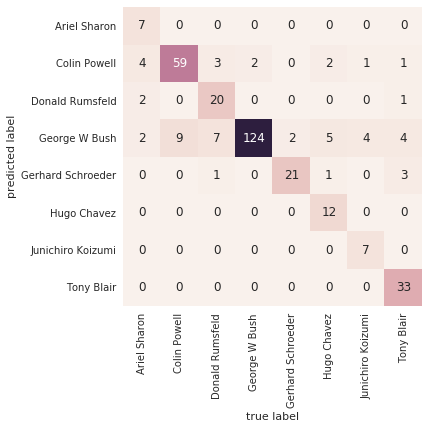

In [19]:
import seaborn as sns; sns.set()


from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Para una tarea de reconocimiento facial en el mundo real, en la que las fotos no vienen pre-recortadas en grillas agradables, la única diferencia en el esquema de clasificación facial es la selección de características: necesitarías usar un algoritmo más sofisticado para encontrar las caras, y extraer características que son independientes de la pixelación. Para este tipo de aplicación, una buena opción es hacer uso de OpenCV.org, que, entre otras cosas, incluye implementaciones pre-entrenadas de herramientas de extracción de características de última generación para imágenes en general y caras en particular.